In [1]:
knitr::opts_chunk$set(echo = TRUE)

In [4]:
install.packages("igraph")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [6]:
install.packages("netcontrol")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘Rdpack’, ‘pracma’, ‘expm’, ‘RcppArmadillo’




In [8]:
install.packages("permute")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [10]:
install.packages("png")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



The dataset here analyzed has been downloaded from https://www.wormatlas.org/neuronalwiring.html. 
The "NeuronConnect.csv" file provides an updated version of C. elegans wiring diagram, covering 6264 synapses, that include chemical synapses and electrical junctions, and 279 neurons. "Neuron1" and "Neuron2" are the names of the neurons connected by an edge, and also the type of the synapses is indicated (S: Send or output, Sp: Send-poly, R: Receive or input, Rp: Receive-poly, EJ: Electric junction, NMJ: Neuromuscular junction). The label "Nbr" indicates the number of synapses between the given neuron pair.

The "NeuronType.csv" file contains neurons names, as well as neuron position, synapse position, and various neuron morphology designations that can be used for further analyses.


In [39]:
options(warn=-1)
library("igraph")
library("RColorBrewer")
library(netcontrol)
library(permute)
library("png")

nodes<-read.csv("NeuronType.csv",header=T,as.is = T, sep =";")
links<-read.csv("NeuronConnect.csv",header=T,as.is = T, sep= ";")
nmj_indexes<-which(links[,2]!="NMJ")
brain_links<-links[nmj_indexes,]
net <- graph_from_data_frame(d=brain_links,nodes,directed=T)
A<-as_adjacency_matrix(net)



# Comparison between the real network and a null model


In [40]:
netsim <-  simplify(net, remove.multiple = F, remove.loops = T)
netsim<-simplify(netsim, edge.attr.comb=list(Weight="sum","ignore"))


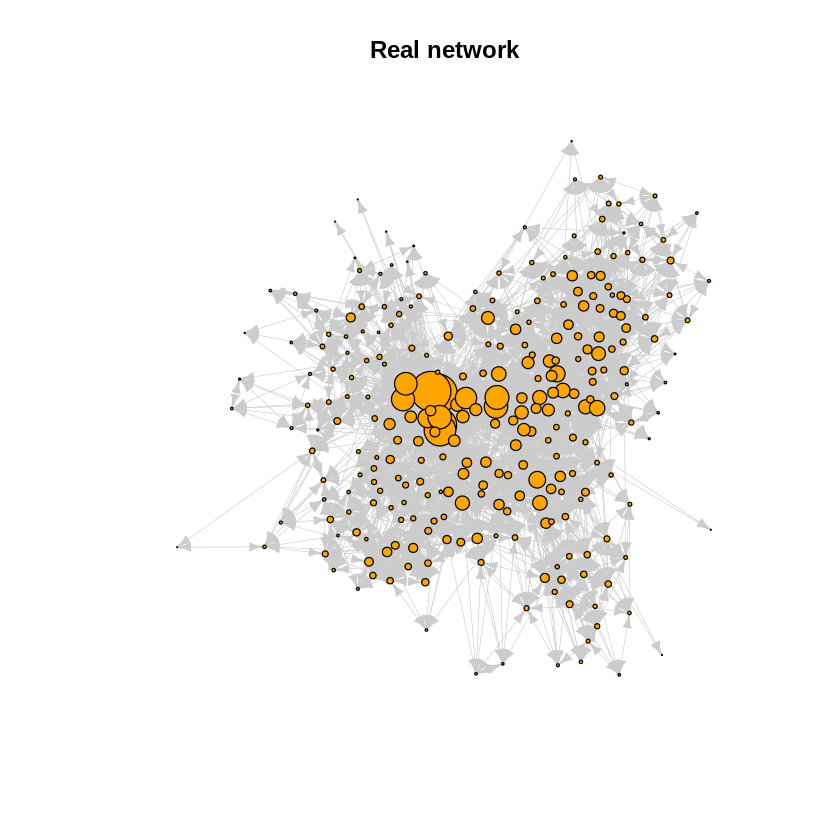

In [41]:
V(netsim)$size<-degree(netsim)*0.08
#col <- brewer.pal(8, "Reds")[3]
V(netsim)$color <- "orange"
E(netsim)$arrow.size<-.5
E(netsim)$width<-.3
plot(netsim, edge.color = "Gray80",vertex.label = NA, layout = layout_with_fr, main = 'Real network')



### Building the random surrogate by fixing the number of nodes and links and rewiring the links


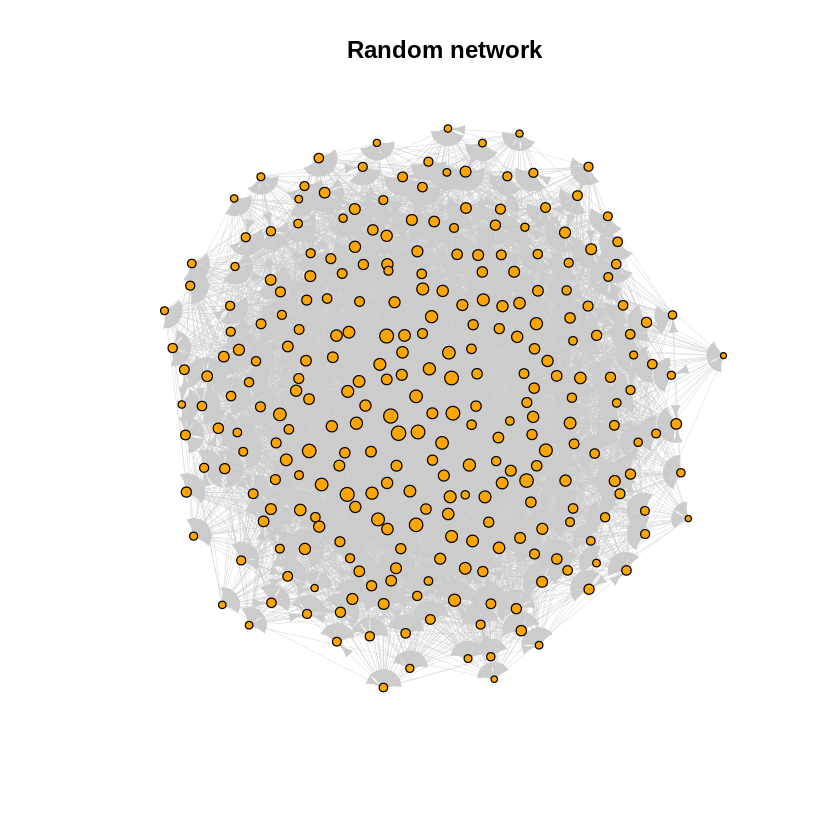

In [47]:
random<-rewire(net, with = each_edge(prob = 1))
Arandom<-as_adjacency_matrix(random)

netsim <-  simplify(random, remove.multiple = F, remove.loops = T)
netsim<-simplify(netsim, edge.attr.comb=list(Weight="sum","ignore"))
V(netsim)$size<-degree(netsim)*0.08
#col <- brewer.pal(8, "Reds")[1]
V(netsim)$color <- "orange"
E(netsim)$arrow.size<-.5
E(netsim)$width<-.3

plot(netsim, edge.color = "Gray80",vertex.label = NA, layout = layout_with_fr, main = 'Random network')


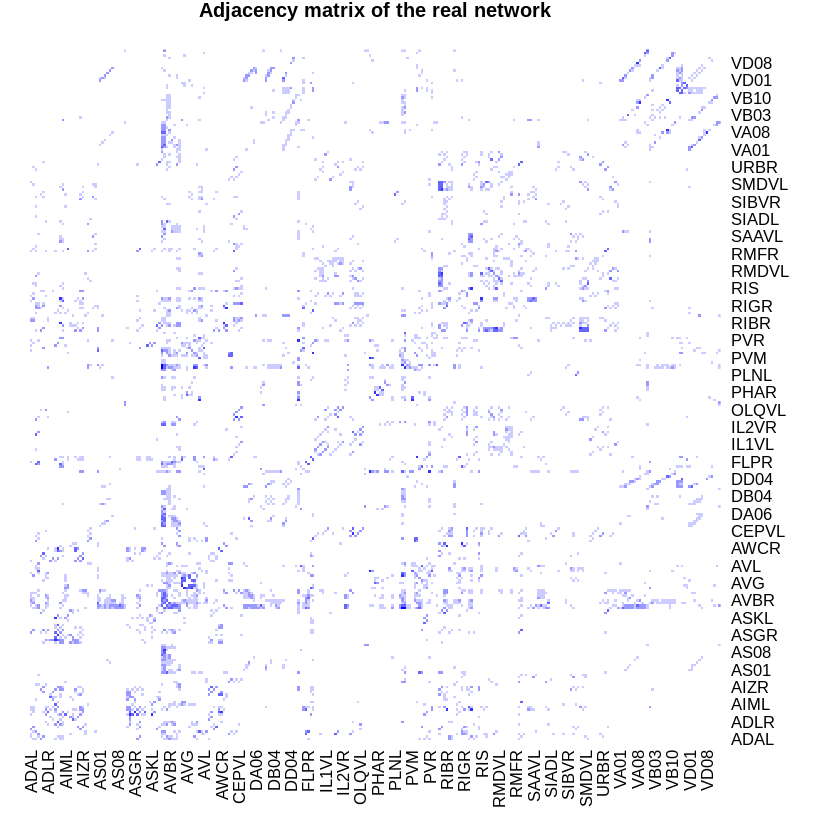

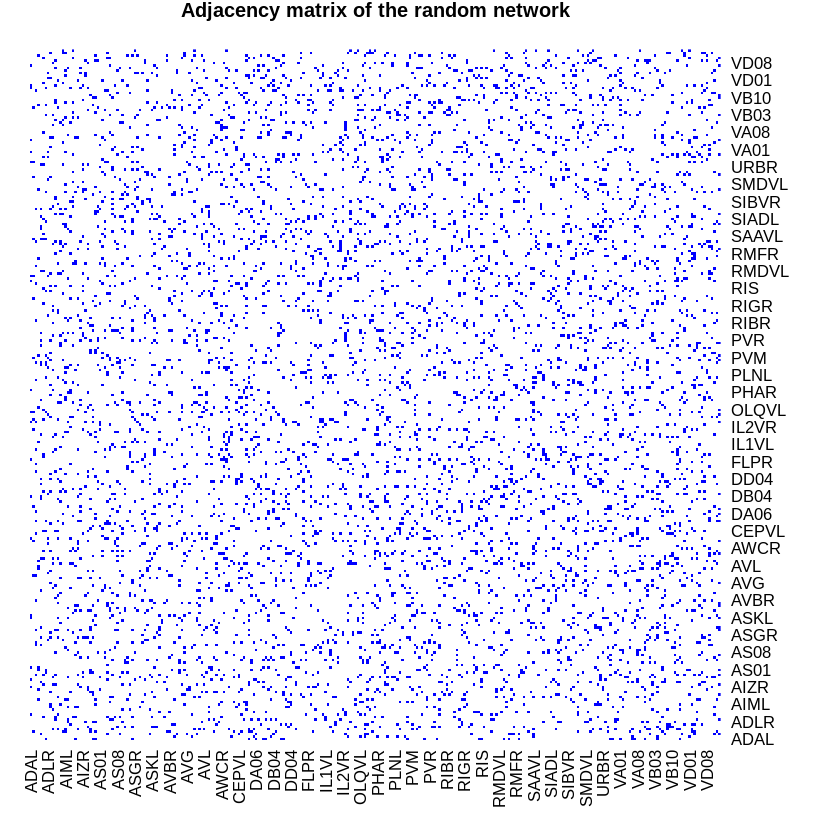

In [15]:
par(cex.main = 0.8)

layout(matrix(c(1,2),1, 2, byrow = TRUE), widths = c(4,4),heights = c(3), TRUE)

palf <- colorRampPalette(c("white", "blue"))
heatmap(as.matrix(A), Rowv = NA, Colv = NA,cexRow =1,cexCol = 1,col = palf(3000),
scale="none", margins=c(5,5), main = 'Adjacency matrix of the real network')
heatmap(as.matrix(Arandom), Rowv = NA, Colv = NA, col = palf(3000),cexRow = 1,cexCol = 1,
scale="none", margins=c(5,5), main = 'Adjacency matrix of the random network')



## Some measures on the real network and the random one


In [16]:
c<-average.path.length(net, directed = TRUE)
crandom<-average.path.length(random, directed = TRUE)
print(c('Average path length:', c))
print(c('Average path length in the random case:', crandom))


[1] "Average path length:" "2.43562569299399"    
[1] "Average path length in the random case:"
[2] "2.07116887135453"                       


In [17]:
diameter(net, directed = TRUE, unconnected = FALSE, weights = NULL)
diameter(random, directed = TRUE, unconnected = FALSE, weights = NULL)


[1] 5

[1] 3

Both the diameter and the average path length are higher in the real network with respect to the random case.
We expect that a random network has the small-world property, i. e. the average distance that grows with $\log{N}$.
Apparently this real network displays less markedly this small world property.


[1] "Mean degree:"     "44.9032258064516"


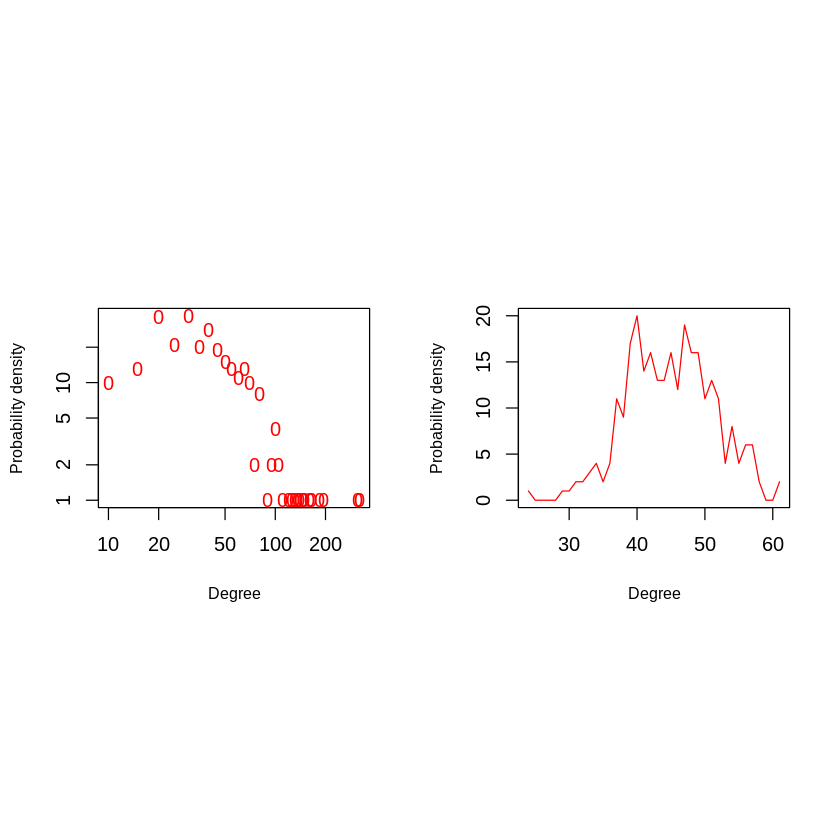

In [18]:
par( cex.lab = 0.8)
nf<-layout(matrix(c(1,2),1, 2, byrow = TRUE), widths = c(8,8),heights = c(8), TRUE)
deg <-hist(degree(net),breaks = 50, plot = FALSE, freq =FALSE)

# deg.dist <- degree_distribution(net, cumulative=T, mode="all")
# plot( x=0:max(degree(net)), y=deg.dist, pch=19,log= 'xy', cex=1.2, col="orange",
# xlab="Degree", ylab="Cumulative Frequency")
# 
# 
# 

plot(deg$breaks[-1],deg$counts, log = 'xy', pch = '0',col = 'red', xlab = 'Degree', ylab = 'Probability density')

deg <-hist(degree(random),breaks = 50, plot = FALSE, freq = FALSE)
plot(deg$breaks[-1],deg$counts, type = 'l',col = 'red',  xlab = 'Degree', ylab = 'Probability density')


# 
# deg.dist <- degree_distribution(random, cumulative=T, mode="all")
# plot( x=0:max(degree(random)), y=deg.dist, pch=19,log = 'xy', cex=1.2, col="orange",
# xlab="Degree", ylab="Cumulative Frequency")

print(c('Mean degree:' ,mean(degree(random))))


When looking at the degree distribution (without considering separately in-degree and out-degree), the real network displays a distribution with heavy tails and some hubs that have large degree, while the random network displays a distribution peaked around the mean degree (44.9).

Looking at the number of components, we see that both real and random network are connected networks.


In [19]:
lapl <- laplacian_matrix(net)
eigvallapl <- eigen(lapl)$values


The number of zero eigenvalues of the Laplacian corresponds to the number of connected components:



In [20]:
numcomponents <-length(eigvallapl[Re(eigvallapl) <10^-12])
#print(numcomponents == components(net)$no)
print(numcomponents)
print(is.connected(net, mode = c('weak', 'strong')))


[1] 1
[1] TRUE


In [21]:
print(components(random)$no)

lapl <- laplacian_matrix(random)
eigvallapl <- eigen(lapl)$values
print(length(eigvallapl[Re(eigvallapl) <10^-12]))


[1] 1
[1] 1



## Centrality measures and clustering coefficient


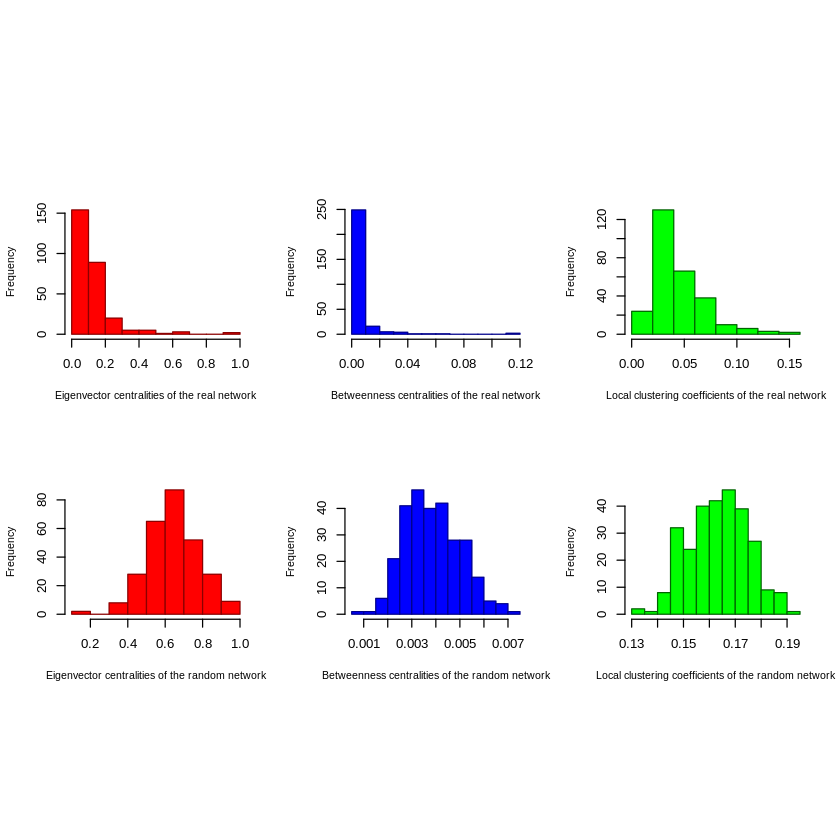

In [22]:
par( cex.lab = 0.8)
nf<-layout(matrix(c(1,2,3,4,5,6), 2,3, byrow = TRUE), widths = c(4,4,4),heights = c(4,4), TRUE)
pr<- hist(eigen_centrality(net, directed = TRUE)$vector,plot = FALSE)
plot(pr, border = "dark red", col = "red",
      main = " ", xlab = "Eigenvector centralities of the real network")
pr<- hist(betweenness(net,v=V(net),directed=TRUE,normalized=TRUE),plot = FALSE)
plot(pr, border = "dark blue", col = "blue",
      main = " ", xlab = "Betweenness centralities of the real network")
pr<- hist(transitivity(net, type = c("local"), vids = NULL, weights = NULL, isolates =c("NaN","zero")),plot = FALSE)
plot(pr, border = "dark green", col = "green",
      main = " ", xlab = "Local clustering coefficients of the real network")

pr<- hist(eigen_centrality(random, directed = TRUE)$vector,plot = FALSE)
plot(pr, border = "dark red", col = "red",
      main = " ", xlab = "Eigenvector centralities of the random network")

pr<- hist(betweenness(random,v=V(random),directed=TRUE,normalized=TRUE),plot = FALSE)
plot(pr, border = "dark blue", col = "blue",
      main = " ", xlab = "Betweenness centralities of the random network")

pr<- hist(transitivity(random, type = c("local"), vids = NULL, weights = NULL, isolates =c("NaN","zero")),plot = FALSE)
plot(pr, border = "dark green", col = "green",
      main = " ", xlab = "Local clustering coefficients of the random network")



## Page Rank Centrality


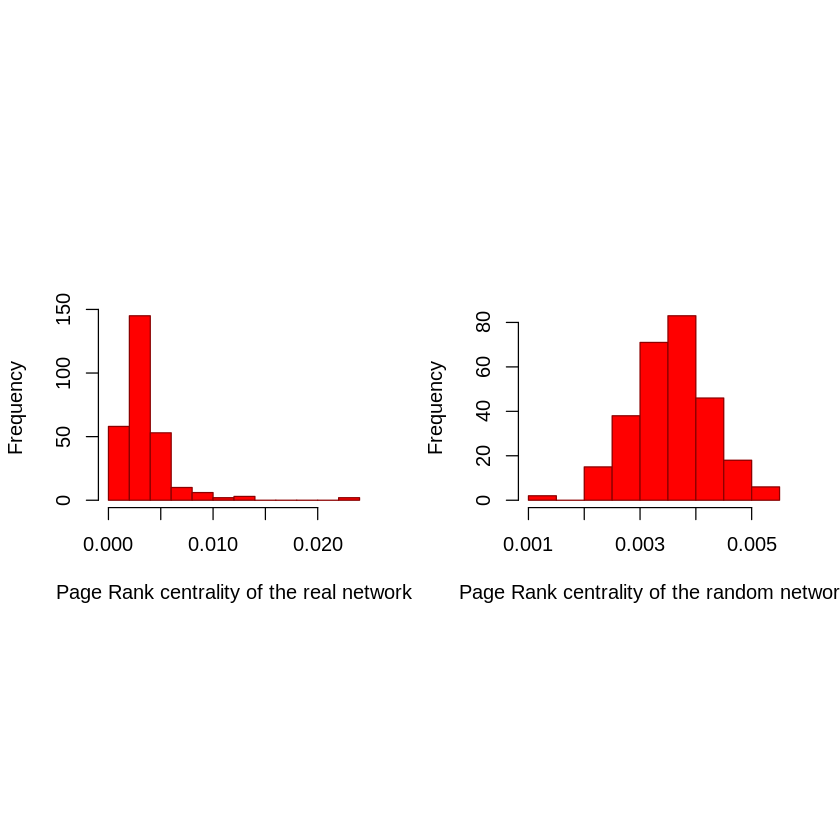

In [23]:
#par( cex.lab = 0.8)
layout(matrix(c(1,2), 1, 2, byrow = TRUE), widths = c(4,4), heights = c(4), TRUE)
pr1<-page_rank(net, algo = c("prpack", "arpack", "power"), vids = V(net),
               directed = TRUE, damping = 0.85, personalized = NULL, weights = NULL,
               options = NULL)
pr<- hist(pr1[[1]],plot = FALSE)
plot(pr, border = "dark red", col = "red",
      main = " ", xlab = "Page Rank centrality of the real network")
prrandom<-page_rank(random, algo = c("prpack", "arpack", "power"), vids = V(random),
               directed = TRUE, damping = 0.85, personalized = NULL, weights = NULL,
               options = NULL)
pr<- hist(prrandom[[1]],plot = FALSE)
plot(pr, border = "dark red", col = "red",
      main = " ", xlab = "Page Rank centrality of the random network")


The page rank centralities in the random network are much more bell shaped and their standard deviation is smaller than in the real case, i. e. they are quite homogeneous among nodes.
The same happens as regard eigenvector centralities, betwenness centralities and clustering coefficients.


In [24]:
global_cluster<-transitivity(net, type = c("global"), vids = NULL,
                             weights = NULL, isolates = c("NaN", "zero"))
print(global_cluster)

rho<-assortativity_degree(net, directed = TRUE)
print(rho)

global_cluster<-transitivity(random, type = c("global"), vids = NULL,
                             weights = NULL, isolates = c("NaN", "zero"))
print(global_cluster)
print(mean(degree(random))/(vcount(random)-1))
rho<-assortativity_degree(random, directed = TRUE)
print(rho)


[1] 0.213481
[1] -0.06205301
[1] 0.1633295
[1] 0.1615224
[1] -0.0022401


In the random null model the global clustering coefficient is lower than the one of the real network.
In a random network the clustering coefficient is approximately $\langle k\rangle/N$, i.e. it tends to diminish with system size, if $\langle k \rangle$ is smaller than $N$.
The real network presents a slightly negative assortativity, meaning that high degree nodes tend to be connected with lower degree nodes, while in the random case it is close to zero.

# Controllability analysis 
## Maximum matching of a bipartite representation


In [25]:
knitr::opts_chunk$set(fig.width=5, fig.height=5)
par(cex.main = 2,
    cex.lab = 1)


The method here applied is taken from https://www.nature.com/articles/nature10011.
To apply the structural controllability framework, first it is necessary to convert a digraph into the bipartite representation and then find the maximum matching on that graph. The number of unmatched nodes would be the number of required driver nodes to control the network.
I first try the method on a random, small network, to see if the method works:


[1] TRUE


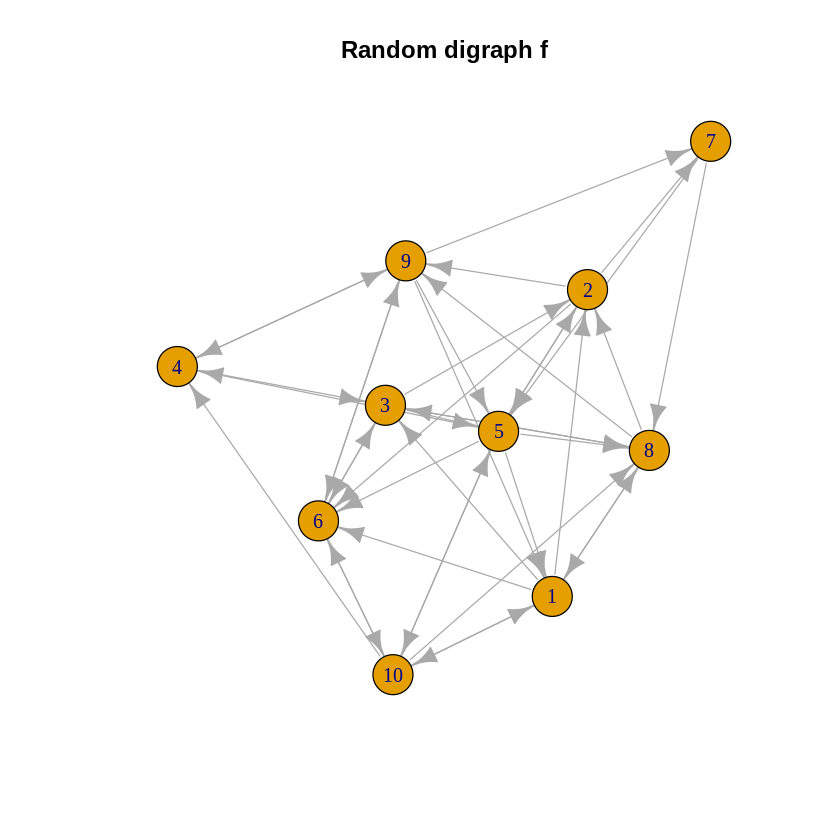

[1] "The size of the maximum matching is:"
[1] 10


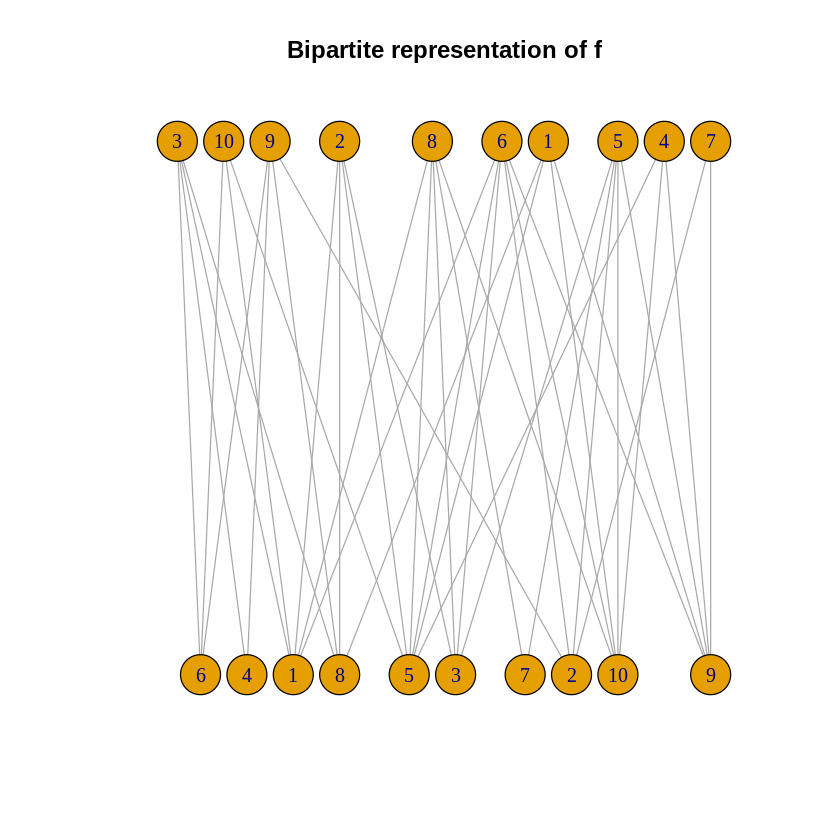

In [48]:
f <- erdos.renyi.game(10,0.5,type = c('gnp'), directed = T)
adj <-as_adjacency_matrix(f)
newadj<-matrix(0, nrow = dim(adj)[1]*2, ncol = dim(adj)[1]*2)
for (i in 1:dim(adj)[1]){
    for (j in 1:dim(adj)[2]){
                 if (adj[i, j] > 0){
                        newadj[i, j + dim(adj)[1]] = adj[i, j]
                        newadj[j + dim(adj)[1], i] = adj[i, j]
                 }
    }
}
bip <-graph_from_adjacency_matrix(newadj,mode =c('undirected'))
V(bip)$label<-c(c(1:10),c(1:10))
V(bip)$type <- c(rep(1, length = dim(adj)[1]), rep(0, length = dim(adj)[1]))
print(is.bipartite(bip))



plot(f, main = 'Random digraph f')
plot(bip, layout = layout_as_bipartite, main = 'Bipartite representation of f')
print('The size of the maximum matching is:')
print(maximum.bipartite.matching(bip)$matching_size)



Now I apply the same method on the C-elegans adjacency matrix.


In [27]:
#library(maxmatching)
#maxmatching(f)
#maxmatching(bip)


In [28]:
adj <-as_adjacency_matrix(net)
newadj<-matrix(0, nrow = dim(adj)[1]*2, ncol = dim(adj)[1]*2)
for (i in 1:dim(adj)[1]){
    for (j in 1:dim(adj)[2]){
                 if (adj[i, j] > 0){
                        newadj[i, j + dim(adj)[1]] = adj[i, j]
                        newadj[j + dim(adj)[1], i] = adj[i, j]
                 }
    }
}
bip <-graph_from_adjacency_matrix(newadj,mode =c('undirected'))
V(bip)$type <- c(rep(1, length = dim(adj)[1]), rep(0, length = dim(adj)[1]))
print(is.bipartite(bip))
print(maximum.bipartite.matching(bip)$matching_size)


[1] TRUE
[1] 279


And on the random surrogate:


In [29]:
adj <- Arandom
newadj<-matrix(0, nrow = dim(adj)[1]*2, ncol = dim(adj)[1]*2)
for (i in 1:dim(adj)[1]){
    for (j in 1:dim(adj)[2]){
                 if (adj[i, j] > 0){
                        newadj[i, j + dim(adj)[1]] = adj[i, j]
                        newadj[j + dim(adj)[1], i] = adj[i, j]
                 }
    }
}
bip <-graph_from_adjacency_matrix(newadj,mode =c('undirected'))
V(bip)$type <- c(rep(1, length = dim(adj)[1]), rep(0, length = dim(adj)[1]))
print(is.bipartite(bip))
print(maximum.bipartite.matching(bip)$matching_size)


[1] TRUE
[1] 279


Since the matching is perfect, it seems that just a single driver node is necessary to structurally control both the real network and the null model. This could be explained by the fact that both networks are not very sparse (the number of edges is much greater the the number of nodes).




## Kalman controllability

The method here applied is taken from https://www.nature.com/articles/ncomms9414, in which a discrete, linear dynamics, described by the adjacency matrix $A$ is assumed.

### Controllability from a single node

Here I study the controllability Gramian considering separately each node as a control point: for each node, the matrix $B$ is a vector of zeros, with the i-th element, corresponding to the i-th node, equal to 1. The controllability analysis reduces to solve a Discrete Lyapunov Equation $AWA^T - W + Q = 0$, in which the matrix $A$ is the adjacency matrix of the data, and the matrix $Q$ is given by $BB^T$. Notably, following  https://www.nature.com/articles/ncomms9414, the matrix $A$ has also to be rescaled (for example dividing it by 1 + its spectral radius) so to make the dynamics it describes stable. I also had to delete a column from $A$, since it was dependent from the other columns and thus $A$ was not invertible. I comment the following lines since they take much time to run, the output is explained below.


In [30]:
# list <- {}
# A<-as_adjacency_matrix(net)
# A1 <- as.matrix(A/(1+max(abs(Re(eigen(A)$values))))) # here I rescale A so to make the dynamics it describes stable
# nnodes<-dim(A1)[1]
# q <-qr(A1)
# mat <- A1[q$pivot[seq(q$rank)], q$pivot[seq(q$rank)]] # here I delete a column that is linearly dependent from the others otherwise "dlyap" gives me error since A1 is not invertible
# 
# for (j in c(1:dim(mat)[1])){
#   B <- matrix(0,nrow =dim(mat)[1], ncol = 1)
#   B[j,1] = 1
#   W <- dlyap(mat,B%*%t(B))
#   list <-c(list,min(Re(eigen(W)$values)))
#   if (min(Re(eigen(W)$values))>0){
#     print(j)
#   }
# }
# print(mean(list))
# print(sd(list))


Here I apply the same method on the random null model.


In [31]:
# list <- {}
# A<-as_adjacency_matrix(random)
# A1 <- as.matrix(A/(1+max(abs(Re(eigen(A)$values))))) # here I rescale A so to make the dynamics it describes stable
# nnodes<-dim(A1)[1]
# 
# 
# q <-qr(A1)
# mat <- A1[q$pivot[seq(q$rank)], q$pivot[seq(q$rank)]]
# 
# for (j in c(1)){
#   B <- matrix(0,nrow =dim(mat)[1], ncol = 1)
#   B[j,1] = 1
#   W <- dlyap(mat,B%*%t(B))
#   list <-c(list,min(Re(eigen(W)$values)))
#   if (min(Re(eigen(W)$values))>0){
#     print(j)
#   }
# }
# print(mean(list))
# print(sd(list))


The variable "list" contains all the minimum eigenvalues of the Gramians of all the nodes. Apparently neither of them is higher than zero, so the network is not controllable from a single node. In the real network, the mean of the minumum eigenvalues is -1.916625e-16 and their standard deviation 3.193487e-16. The minimum eigenvalues thus are clearly compatible with zero, and the situation is very similar in the random case. In general, the fact that this method is subject to numerical problems, plus the fact that the adjacency matrix has to be rescaled (and also dependent columns have to be deleted...) makes possible biological interpretation difficult. I found the result quite sensitive to the factor by which the matrix $A$ is rescaled.

### Brain controllability with a finite energy and role of node centralities

Here I sort nodes of the real network according to two centrality measures (out degree centrality and betweenness centrality) and then according to a random order, and consider the first k number of nodes in the ranking as the k control points. Then I apply the same procedure on the random nework, by ranking the nodes according to degree centrality. I estimate the minimum number of nodes to control the network. The minimum eigenvalue of the Gramian is greater than zero when considering 44/39/41 nodes in the real network and 33 nodes in the case of a random network. However, the minimum eigenvalue at that stage is still numerically compatible with zero. Setting a threshold in the energy required to control the network, and looking at how many nodes are necessary to achieve control, given that fixed energy, could be a better way to investigate numerically the controllability, as it is done here https://www.sciencedirect.com/science/article/abs/pii/S1053811918302982. So, in the following code I fix the energy to $10^{10}$ and look for the number of nodes needed to control the network, given this energy. In the real network, 87 (ranked by degree centrality), 82, (ranked by betweenness centrality), 72 (ranked in a random order) nodes are necessary to control the network given the fixed energy. Selecting nodes according to the centrality measure thus doesn't seem to bring advantages in the controllability. In the random case the number of nodes needed seems much lower (54). These results are still affected by numerical problems, but they might be in accordance with the result of https://www.nature.com/articles/nature10011, that shows that random homogeneus networks are more easily controllable than heterogeneous networks such as the scale free ones.


In [32]:
energy <-10^10
emin<-1/energy
# Nodes are ordered on the basis of out degree
list <- {}
A<- as_adjacency_matrix(net)
A1 <- as.matrix(A/(1+max(abs(Re(eigen(A)$values))))) # here I rescale A so to make the dynamics it describes stable
nnodes<-dim(A1)[1]
q <-qr(A1)
mat <- A1[q$pivot[seq(q$rank)], q$pivot[seq(q$rank)]]
r <-degree(net,v=V(net),mode = c('out'))
r <- r[q$pivot[seq(q$rank)]]
index <- sort(r, decreasing  = T,index.return=T)$ix
ncon <- dim(mat)[1]
B <- matrix(0,nrow =dim(mat)[1], ncol = ncon)
co <- 1
for (j in c(index)){
  B[j,j] = 1
  W <- dlyap(mat,B%*%t(B))
  list <-c(list,min(Re(eigen(W)$values)))
  if(min(Re(eigen(W)$values))>=emin){
   break
  }
  co = co + 1
}
print(co)


[1] 87


In [33]:
list <- {}
A<- as_adjacency_matrix(net)
A1 <- as.matrix(A/(1+max(abs(Re(eigen(A)$values))))) # here I rescale A so to make the dynamics it describes stable
nnodes<-dim(A1)[1]
q <-qr(A1)
mat <- A1[q$pivot[seq(q$rank)], q$pivot[seq(q$rank)]]
r <-betweenness(net,v=V(net),directed=TRUE,normalized=TRUE)
r <- r[q$pivot[seq(q$rank)]]
index <- sort(r, decreasing  = T,index.return=T)$ix
ncon <- dim(mat)[1]
B <- matrix(0,nrow =dim(mat)[1], ncol = ncon)
co <- 1
for (j in c(index)){
  B[j,j] = 1
  W <- dlyap(mat,B%*%t(B))
  list <-c(list,min(Re(eigen(W)$values)))
  if(min(Re(eigen(W)$values))>=emin){
    break
  }
  co = co + 1
}
print(co)


[1] 82


Here instead I select nodes in random order.


In [34]:
list <- {}
A<- as_adjacency_matrix(net)
A1 <- as.matrix(A/(1+max(abs(Re(eigen(A)$values))))) # here I rescale A so to make the dynamics it describes stable
nnodes<-dim(A1)[1]
q <-qr(A1)
mat <- A1[q$pivot[seq(q$rank)], q$pivot[seq(q$rank)]]
index <- c(1:vcount(net))[seq(q$rank)]
index<- shuffle(index)
ncon <- dim(mat)[1]
B <- matrix(0,nrow =dim(mat)[1], ncol = ncon)
co <- 1
for (j in c(index)){
  B[j,j] = 1
  W <- dlyap(mat,B%*%t(B))
  list <-c(list,min(Re(eigen(W)$values)))
  if(min(Re(eigen(W)$values))>= emin){
    break
  }
  co = co +1
}
print(co)


[1] 72


Here I do the same on the random network, by ranking the nodes according to their out degree


In [35]:
network <-random
list <- {}
A<- as_adjacency_matrix(network)
A1 <- as.matrix(A/(1+max(abs(Re(eigen(A)$values))))) # here I rescale A so to make the dynamics it describes stable
nnodes<-dim(A1)[1]
q <-qr(A1)
mat <- A1[q$pivot[seq(q$rank)], q$pivot[seq(q$rank)]]

r <-degree(network,v=V(network),mode = c('out'))
r <- r[q$pivot[seq(q$rank)]]
index <- sort(r, decreasing  = T,index.return=T)$ix
ncon <- dim(mat)[1]
B <- matrix(0,nrow =dim(mat)[1], ncol = ncon)
co <- 1
for (j in c(index)){
  B[j,j] = 1
  W <- dlyap(mat,B%*%t(B))
  list <-c(list,min(Re(eigen(W)$values)))
  if(min(Re(eigen(W)$values))>=emin){
    break
  }
  co = co +1
}
print(co)


[1] 54
